## <center>Business Analytics - Assignment 1
Compute the required amount of
account managers and involved
traveling distance for EMTE.
EMTE is a supermarket chain in the Netherlands
with about 130 stores. EMTE likes to know how
many account managers they need to visit all the
stores in one day, and how many kilometers they need to travel in total together. Their main
objective is to minimize the total traveling distance rather than the amount of account managers.
Every account manager starts and ends at the headquarters. Due to the maximum working time of
the account manager, every account manager can drive a maximum of 400 km per day. In other
words: the task is to solve a VRP for this problem. The goal is to minimize the total distance. You can
use the haversine formula in Matlab or Python to compute the distance between two locations.

<img src="https://media.giphy.com/media/FDHO8sbi4hl8qsABDv/giphy.gif">

**<a name="table">Table of Contents</a>  **

1. [Functions](#functions)

2. [Deepcopy](#deepcopy)

3. [Prepare Data](#preparedata)

4. [Exercise 1 - ILP](#exercise1)
    
5. [Exercise 2 - NN](#exercise2)
    
6. [Exercise 3](#exercise3) 

    6.1 [City Swap (consecutive)](#cityswap)
    
    6.2 [City Swap (between routes)](#cityswapext)

    6.3 [Two-opt exchange (within routes)](#twoopt)

    6.4 [Two-opt exchange (between routes)](#twooptb)
    
    6.5 [Transfer Cities](#citytransfer)
    
    6.6 [Remove Routes](#removeroutes)
    
    6.7 [Swap Subroutes](#swap)

    6.8 [Tabu Search](#tabu)

7. [Exercise 4](#exercise4)

    7.1 [Simmulated Annealing](#siman)
    
    7.2 [Ant Colony Optimization](#aco)

8. [Exercise 5](#exercise5)

    8.1 [Functions](#functions5)

    8.2 [Nearest Neighbor](#nn5)
    
    8.3 [Tabu Search](#tabu5)
    
    8.4 [ILP Version](#ilp5)

### <a name="functions">1. Functions</a> 
[Back to Table of Contents](#table)

These functions are used for exercises 1, 2, 3 and 4. Exercise 5 has its own set of functions due to having different constraints. 

In [124]:
import pulp
import collections
import time
import random
import folium
import pants
import math

import pandas              as pd
import numpy               as np
import matplotlib.pyplot   as plt

from copy                          import deepcopy 
from haversine                     import haversine
from __future__                    import print_function
from simanneal                     import Annealer
from sklearn.metrics.pairwise      import pairwise_distances

def get_route_ilp(VRP):
    """ Extract the routes from pulp
    
    The function aims to extract the routes from 
    pulp as those are saved a bit messy. 
    
    Parameters:
    -----------
        VRP (pulp): The full VRP solution
    
    Returns:
    -----------
        dict(int, list): dictionary of multiple routes
    
    """
    temp_routes = {}

    for v in VRP.variables():
        if (v.varValue == 1) and ('Edge_' in str(v)):
            route_number = int(str(v.name).split('_')[-1].split(')')[0])
            from_city = int(str(v.name).split('(')[1].split(',')[0])
            to_city = int(str(v.name).split('(')[1].split('_')[1].split(',')[0])
            if int(from_city) == 0:
                temp_routes[route_number] = {}
                temp_routes[route_number][from_city] = to_city
            else:
                temp_routes[route_number][from_city] = to_city

    ilp_routes = {}

    for route in temp_routes:
        temp_route = [0]
        for i in range(len(temp_routes[route])):
            temp_route.append(temp_routes[route][temp_route[-1]])
        ilp_routes[route] = [0, temp_route]
    
    return ilp_routes

def get_distance_matrix(cities):
    """ Create a numpy distance matrix for pulp
    
    A numpy distance matrix is created of all the 
    cities in order for pulp to work with it. 
    
    Parameters:
    -----------
        cities (dataframe): Dataframe of all cities
    
    Returns:
    -----------
        dist_matrix (numpy): Numpy distance matrix
    """
    distance_matrix = np.zeros((cities.shape[0], cities.shape[0]))
    
    coordinates = cities[["Lat", "Long"]].values
    
    for i in range(distance_matrix.shape[0]):
        for j in range(distance_matrix.shape[1]):
            distance_matrix[i][j] = haversine\
            ((coordinates[i][0],coordinates[i][1]), 
             (coordinates[j][0],coordinates[j][1]))
            
    return distance_matrix

def get_distance_route(route):
    """ 
    Get total distance for a single route
    with HQ being both the start and finish

    Parameters:
    -----------
        route (list) : List of route with cities as int. 

    Returns:
    --------
        total_distance (float): Distance in km.
        
    Example:
    --------
        >>>> get_distance_route([0, 120, 3, 2, 0])
        414.746557867148

    """
    
    total_distance = 0
    
    for i in range(len(route)-1):
        city_1 = route[i]
        city_2 = route[i+1]
        total_distance += distances_dict[city_1][city_2]
        
    return total_distance

def get_distance_routes(routes):
    """ 
    Return the total distance for a set of routes
    with HQ being both the start and finish
        
        
    Parameters:
    -----------
        route (dict of list): Dict of lists of multiple routes
                              with cities as int. 

    Returns:
    --------
        total_distance (float): Total distance in km.

    Example:
    --------
        >>>> get_distance_route(set_of_routes)
        914.746557867148
    """
    
    total_distance = 0
    
    for i in routes:
        route = routes[i][1]
        
        for j in range(len(route)-1):
            city_1 = route[j]
            city_2 = route[j+1]
            total_distance += distances_dict[city_1][city_2]
            
    return total_distance

def nearest_neighbor(df):   
    """ Returns a list of routes based on an implementation
        of the nearest neighbor heuristic. The routes have
        the following constraints:
           * Every route cannot be longer than 400km
           * No subroutes are allowed
           * All cities in a route are not visited in another route
                   
    Parameters:
    -----------
        df (dataframe): Distance matrix of distances between each city

    Returns:
    --------
        routes (dictionary): Dictionary of lists which contain cities 
                            in the correct order
    """
    routes = {}

    while len(df) > 1:    
        current_city = 0
        total_distance = 0
        route = [0, 0]
        
        while True:
            # Find closest city
            new_city_distance = df.drop([current_city, 0], axis=1).ix[current_city].min()
            new_city = int(df.drop([current_city, 0], axis=1).ix[current_city].idxmin())
            distance_to_hq = df.ix[new_city][0]

            # Check if "future" distance matches with current distance
            if (total_distance + new_city_distance + distance_to_hq) < 400:

                # Remove city from places to visit
                if current_city != 0:
                    df = df.drop(current_city)
                    df = df.drop(current_city, axis = 1)

                # Update Route and set the starting city to the closest one
                current_city = new_city
                route.insert(-1, int(new_city))
                total_distance += new_city_distance

                # If there is only 1 city left we take that as a single route
                if len(df) == 2:                   
                    total_distance += distance_to_hq
                    routes[len(routes) + 1] = [total_distance, route]
                    df = df.drop(current_city)
                    break

            # Signifies the end of a route
            else:
                total_distance += distance_to_hq
                routes[len(routes) + 1] = [total_distance, route]
                df = df.drop(current_city)
                df = df.drop(current_city, axis = 1)
                break
                
    return routes

def plot_routes(routes, method = '', figure_size = (10, 8)):
    """ Show a plot of all routes that are created with different colors
         
    Parameters:
    -----------
        routes (dict of lists): Distance matrix of distances between each city
        method (string): Assigns method to title
        figure_size (tuple): Change figure size
    
    """
    
    # Create figure with distance in title
    sum_distance = sum([get_distance_route(routes[route][1]) for route in routes])
    plt.figure(figsize=figure_size)
    plt.title("Distance: {}. Method: {}".format(round(sum_distance, 4), method))

    # Create subplot for each route
    for route in routes:
        xseries = [df.Long.iloc[index] for index in routes[route][1]]
        yseries = [df.Lat.iloc[index] for index in routes[route][1]]
        plt.scatter(xseries,yseries)
        plt.plot(xseries,yseries,linestyle='-', marker='o')
    
    # For easier visability
    plt.xlim(3.3,7.1)
    plt.ylim(51.0,53.15)
    plt.show()
    
def fancy_plot(routes):
    """ Show a fancy plot of all routes that are created with different colors
        using folium to show the map of the Netherlands
        
    Parameters:
    -----------
        routes (dict of lists): Distance matrix of distances between each city
    """
    # Create list of (lat, long)
    points = []
    for i in range(len(df)):
        points.append(tuple([df.Lat.values[i], df.Long.values[i]]))
    
    # Create map with certain size
    ave_lon = sum(p[1] for p in points)/len(points)
    ave_lat = 52.15
    my_map = folium.Map(location=[ave_lat, ave_lon], zoom_start=7, 
                        height = '80%', width = '80%') 
    points_routes = {j: [(df.Lat[i], df.Long[i]) for i in routes[j][1]] 
                     for j in routes}
    
    # Plot points onto map
    colors = ['blue', 'green', 'red', 'black', 'purple', 'orange', 'brown']
    for route in points_routes:
        folium.PolyLine(points_routes[route], color = colors[route-1], 
                        weight=2, opacity=0.8).add_to(my_map)

        for point in points_routes[route]:
            folium.CircleMarker(location=point, radius=2,fill= True,
                                fill_opacity = 1, color = colors[route-1],
                                weight=1).add_to(my_map)
    return my_map
    
def city_swap(route): 
    """ Single iteration of a consecutive city swap
    
    City swap is implemented as a within-route consecutive
    city swap. In other words, it tries to swap consecutive 
    cities in a single route and returns a route as soon
    as it is better then the starting route. 
    
    Parameters:
    -----------
        route (list): Route with cities as integers in a list
        
    Returns:
    -----------
        list(float, list): list(distance of top route, the top route)
    
    """
    top_route = deepcopy(route)
    top_route_distance = get_distance_route(route)
    
    if len(route) > 3:
        for i in range(1, len(route)-2):
            temp_route = deepcopy(top_route)
            temp_route[i], temp_route[i+1] = temp_route[i+1], temp_route[i]
            if get_distance_route(temp_route) < top_route_distance:
                top_route = temp_route
    
    return [top_route_distance, top_route]


def city_swap_extended(routes):
    """ A between route version of city swap
    
    An extended version of the consecutive city swap. 
    This heuristic tries to swap each cities in a route
    with the closest city in another route. It returns
    as soon as it finds a solution that is better than 
    the initial solution. 
    
    Parameter:
    -----------
        routes (dict(int, list)): dictionary of multiple routes
    
    Returns:
    -----------
        dict(int, list): dictionary of multiple routes
    
    """
    # Initialize top route and distance
    top_routes = deepcopy(routes)
    top_distance = get_distance_routes(top_routes)
    
    for route_1 in top_routes:
        for route_2 in top_routes:
            for ix_1, city in enumerate(top_routes[route_1][1]):
                if (city != 0) & (route_1 != route_2) & (len(top_routes[route_2][1]) > 2):
                    
                    # Find the closest city in another route
                    temp = deepcopy(top_routes)
                    city_2 = {key: distances_dict[city][key] for key in temp[route_2][1]}
                    city_2.pop(0, None)
                    city_2.pop(city, None)
                    city_2 = min(city_2, key=city_2.get)
                    ix_2 = temp[route_2][1].index(city_2)
                    
                    # Swap the cities between routes
                    temp[route_1][1][ix_1], temp[route_2][1][ix_2] = temp[route_2][1][ix_2],\
                                                                     temp[route_1][1][ix_1]
                    temp_distance = [get_distance_route(temp[i][1]) for i in temp]                    
                    
                    # Check if it fits the constraints and better then initial solution
                    if (all(dist < 400 for dist in temp_distance)) and (sum(temp_distance) <\
                                                                        top_distance):
                        top_routes = deepcopy(temp)
                        top_distance = temp_distance
                        return top_routes

    return top_routes

def two_opt_step(route):
    """ Single iteration of a two-opt exchange
    
    This version of two-opt exchange is implemented as an within
    route two-opt exchange. Thus, within a route, a piece of the
    route is reversed in order to possibly optimize the route. 
    It returns as soon as it finds a better solution than the
    initial route. 
    
    Parameters:
    -----------
        route (list): Route with cities as integers in a list
    
    Returns:
    -----------
        list(float, list): list(distance of top route, the top route)
    
    """
    top_route = route
    top_route_distance = get_distance_route(route)
    
    if len(route) > 2:
        for i in range(1, len(route)-2):
            for j in range(i+1, len(route)):
                temp_route = route[:i] + route[i:j][::-1] + route[j:]
                temp_route_distance = get_distance_route(temp_route)

                if temp_route_distance < top_route_distance:                   
                    top_route = temp_route
                    top_route_distance = temp_route_distance
                    return [top_route_distance, top_route]
                    
    return [top_route_distance, top_route]

def two_opt_step_ext(routes):
    """ Single iteration of a two-opt exchange
    
    A single iteration of a two-opt exchange between
    different routes. The heuristic takes two routes and 
    splits both of them in a random point to create the following
    routes: 1A, 1B, 2A and 2B. Then, the routes are combined as
    follows: (1A2A and 1B2B) or (1A2B, 1B2A). The algorithm checks
    which one is better and returns as soon as the new route is 
    better than the initial route. 
    
    Parameter:
    -----------
        routes (dict(int, list)): dictionary of multiple routes
    
    Returns:
    -----------
        dict(int, list): dictionary of multiple routes
    
    """
    top_routes = routes
    top_distance = get_distance_routes(routes)
    
    for route_1 in top_routes:
        for route_2 in top_routes:
            # Make sure only valid routes are selected
            if (route_1 != route_2) & (len(top_routes[route_1][1])>3)\
                & (len(top_routes[route_2][1])>3):
                    
                for i in range(1, len(top_routes[route_1][1])-1):
                    # Temporary copies are needed
                    temp_route = deepcopy(top_routes)
                    temp_route_2 = deepcopy(top_routes)
                    
                    # Get a random cut-off point for the second route
                    j = {key: distances_dict[i][key] for key in temp_route[route_2][1]}
                    j.pop(0, None)
                    j.pop(i, None)
                    j = random.choice(list(j))
                    j = temp_route[route_2][1].index(j)
                    
                    # 1A2A and 1B2B
                    temp_route[route_1][1] = top_routes[route_1][1][:i] + \
                                             top_routes[route_2][1][j:]
                    temp_route[route_2][1] = top_routes[route_2][1][:j] + \
                                             top_routes[route_1][1][i:]
                    
                    # 1A2B and 1B2A
                    temp_route_2[route_1][1] = top_routes[route_1][1][:i] + \
                                               top_routes[route_2][1][1:j][::-1] + [0]
                    temp_route_2[route_2][1] = top_routes[route_2][1][j:][::-1] + \
                                               top_routes[route_1][1][i:]
                    
                    # Get distances and find the best
                    temp_distance = [get_distance_route(temp_route[i][1]) 
                                     for i in temp_route]                    
                    temp_distance_2 = [get_distance_route(temp_route_2[i][1]) 
                                       for i in temp_route_2]                    
                    if sum(temp_distance_2) < sum(temp_distance):
                        temp_route = temp_route_2
                        temp_distance = temp_distance_2
                    
                    # Check for constraint and returns if new route is better
                    if (all(dist < 400 for dist in temp_distance)) & (sum(temp_distance) \
                                                                      < top_distance):
                            return temp_route
    return top_routes


def transfer_cities(routes):
    """ Heuristic to transfer cities to a new route
    
    This heuristic tries to move a city from one route
    to another in order to improve the resulting routes. 
    Implicity, it tries to lower the number of routes as 
    moving a city from a route with a single city reduces
    the total distance. 
            
    Parameter:
    -----------
        routes (dict(int, list)): dictionary of multiple routes
    
    Returns:
    -----------
        dict(int, list): dictionary of multiple routes
    
    """
    
    # Initialize top route and distance
    top_routes = deepcopy(routes)
    top_distance = get_distance_routes(top_routes)

    for route_1 in top_routes:
        for route_2 in top_routes:
            for ix_1, city in enumerate(top_routes[route_1][1]):
                if (city != 0) & (route_1 != route_2) & (len(top_routes[route_2][1])>2):
                    
                    # Find closest city 
                    temp = deepcopy(top_routes)
                    city_2 = {key: distances_dict[city][key] for key in temp[route_2][1]}
                    city_2.pop(0, None)
                    city_2.pop(city, None)
                    city_2 = min(city_2, key=city_2.get)
                    ix_2 = temp[route_2][1].index(city_2)
                    
                    # Move city to new route and calculate new distance
                    temp[route_2][1].insert(ix_2, city)
                    del temp[route_1][1][ix_1]
                    temp_distance = [get_distance_route(temp[i][1]) for i in temp]                    

                    # Check if solution is better
                    if (all(dist < 400 for dist in temp_distance)) and (sum(temp_distance) <\
                                                                        top_distance):
                        if len(temp[route_1][1]) < 3:
                            del temp[route_1]
                            return temp
                        else:
                            return temp  
    return top_routes


def remove_routes(routes):
    """ Heuristic to decrease the amount of routes
    
    This heuristic tries to move all cities in the 
    smallest route to any other routes in order to 
    minimize the number of routes. It allows for a worse
    solution in order to decrease the number of routes
    and perhaps explore more possible neighborhoods. 
    It returns as soon as it has moved a city in the smallest
    route to any other route and if it fits the constraints.
    
    Parameter:
    -----------
        routes (dict(int, list)): dictionary of multiple routes
    
    Returns:
    -----------
        dict(int, list): dictionary of multiple routes
    
    """

    # Initialize top route and distance
    top_routes = deepcopy(routes)
    top_distance = get_distance_routes(top_routes)
        
    # Find smallest route
    smallest_route = {i: len(routes[i][1]) if len(routes[i][1]) > 2 else 100 for i in routes}
    smallest_route = min(smallest_route, key=smallest_route.get)
    
    for route in top_routes:
        for city in range(1, len(top_routes[route][1])-1):
            for ix_1, city_1 in enumerate(top_routes[smallest_route][1]):
                if (city_1 != 0) & (route != smallest_route):
                    
                    # Move a city to a new route and calculate new distance
                    temp = deepcopy(top_routes)
                    temp[route][1].insert(city, city_1)
                    del temp[smallest_route][1][ix_1]
                    temp_distance = [get_distance_route(temp[i][1]) for i in temp]    
                    
                    # Check if the new route fits the constraints
                    if all(dist < 400 for dist in temp_distance):
                        if len(temp[smallest_route][1]) < 3:
                            del temp[smallest_route]
                            return temp
                        else:
                            return temp
    return top_routes

def swap(routes):
    """ Single iteration of a subroute swapper
    
    This heuristic swaps a random subroute of one route
    with the subroute of another. This is an extension
    of the two-opt exchange between different routes. 
    It returns as soon as the route is improved
    
    For example:
    ------------
        route_1 = [0, 1, 2, 3, 4, 5, 6, 0]
        route_2 = [0, 7, 8, 9, 10, 11, 12, 0]
        
        The algorithm may randomly swap subroute [3, 4] 
        in route_1 with subroute [7, 8, 9, 10] in route_2 to 
        get the following results:
        
        route_1 = [0, 1, 2, 7, 8, 9, 10, 5, 6, 0]
        route_2 = [0, 3, 4, 11, 12, 0]
        
    Parameter:
    -----------
        routes (dict(int, list)): dictionary of multiple routes
    
    Returns:
    -----------
        dict(int, list): dictionary of multiple routes
    
    """
    # Initialize top route and distance
    top_routes = routes
    top_distance = get_distance_routes(routes)
    
    for route_1 in top_routes:
        for route_2 in top_routes:
            if (route_1 != route_2) & (len(top_routes[route_1][1])>3)\
                    & (len(top_routes[route_2][1])>3):
                for _ in range(10):
                    # Get random subroutes
                    i = random.randint(1, len(top_routes[route_1][1])-3)
                    j = random.randint(i+1, len(top_routes[route_1][1])-1)
                    k = random.randint(1, len(top_routes[route_2][1])-3)
                    l = random.randint(k+1, len(top_routes[route_2][1])-1)

                    # Swap subroutes
                    temp_route = deepcopy(top_routes)

                    temp_route[route_1][1] = top_routes[route_1][1][:i] + \
                                             top_routes[route_2][1][k:l] +\
                                             top_routes[route_1][1][j:]

                    temp_route[route_2][1] = top_routes[route_2][1][:k] + \
                                             top_routes[route_1][1][i:j] +\
                                             top_routes[route_2][1][l:]
                    
                    # Get distances
                    temp_distance = [get_distance_route(temp_route[i][1]) 
                                     for i in temp_route]                    

                    # Check for constraint and returns if new route is better
                    if (all(dist < 400 for dist in temp_distance)) & (sum(temp_distance) \
                                                                      < top_distance):
                            return temp_route
    return top_routes

def tabu_search(routes, max_iter=400, strategy = 800):
    """ Tabu search heuristic
    
    An implementation of the tabu search heuristic. 
    It uses six heuristics (see functions for describtions):
        * Concecutive city swap (within routes) 
        * City swap (between routes)
        * Two opt exchange (within routes)
        * Two opt exchange (between routes)
        * Transfer cities
        * Remove cities
        * Swap Sub Routes
        
    For each iteration tabu search runs the six heuristics
    and randomly picks a solution. These are random walks that
    are executed in order to explore neighborhoods that might
    lead to a better solution: 
    
    Random walks: http://www-verimag.imag.fr/PUBLIS/uploads/hlevf2616.pdf
    
    The randomness of the implementation allows for different 
    neighborhoods to be possible. Moreover, a tabu list is implemented
    in order to allow the search to go back to an already seen solution
    and go into a different neighborhood. 
    
    It returns after a certain amount of iterations if there
    has been no improvent for 10 consecutive iterations.
    
    Parameter:
    -----------
        routes (dict(int, list)): dictionary of multiple routes
        max_iter (int): Number of maximum iterations
        strategy (int): When the number of iterations are lower than
                        this value, only select solutions that are
                        better. Otherwise, use random solution
    
    Returns:
    -----------
        dict(int, list): dictionary of multiple routes
    
    
    """
    # Initialize variables
    best_routes = deepcopy(routes)
    best_solution = get_distance_routes(routes)
    length_tabu = 10
    tabu_list = collections.deque(maxlen=length_tabu)
    k = 0
    result_list = [best_solution] 
    route_list = [{'start': best_routes}]
    random_route = 'None'
    
    start_time = time.time()
    
    while k < max_iter:    
        # Create neighborhood consisting of the following heuristics:
        
        try:
            results_two_opt = {i: two_opt_step(best_routes[i][1]) for i in best_routes}
            results_two_opt_ext = two_opt_step_ext(best_routes)
            results_city_swap = {i: city_swap(best_routes[i][1]) for i in best_routes}
            results_city_ext = city_swap_extended(best_routes)
            results_transfer = transfer_cities(best_routes)
            results_remove = remove_routes(best_routes)
            results_swap = swap(best_routes)
        except:
            print('fail!')
            return best_routes, result_list, route_list 
        
        routes = {'Swap': results_city_swap,
                 'Ext': results_city_ext,
                 'Two_opt': results_two_opt,
                 'Transfer': results_transfer,
                 'Remove': results_remove,
                 'Two_opt_ext': results_two_opt_ext,
                 'Sub_swap': results_swap}
        
        dist = {'Swap': get_distance_routes(results_city_swap),
                'Ext': get_distance_routes(results_city_ext),
                'Two_opt': get_distance_routes(results_two_opt),
               'Transfer': get_distance_routes(results_transfer),
               'Remove': get_distance_routes(results_remove),
               'Two_opt_ext': get_distance_routes(results_two_opt_ext),
               'Sub_swap': get_distance_routes(results_swap)}
        
        # Randomly select new route
        if k<strategy:
            random_route = random.choice(list(routes.keys()))
            new_best_routes = routes[random_route] # get random solution
        else:
            new_best_routes =  routes[min(dist.items(), key=lambda x: x[1])[0]]


        new_best_solution = get_distance_routes(new_best_routes) 
        tabu_list.appendleft(new_best_routes)                  
        
        # Use new routes if better than old otherwise check tabu list
        if new_best_solution < best_solution:
            best_solution = deepcopy(new_best_solution)
            best_routes = deepcopy(new_best_routes)
        else:
            random_int = np.random.randint(0,len(tabu_list))
            best_routes = tabu_list[random_int]
            best_solution = get_distance_routes(tabu_list[random_int])
            
        # Update routes
        result_list.append(new_best_solution)
        route_list.append({random_route: best_routes})
        k += 1
        
        # Check if improvement in last 10 iterations
        if (all(x==tabu_list[0] for x in tabu_list)) & (len(tabu_list) == length_tabu):
            return best_routes, result_list, route_list
        
        # To check progress of algorithm
        if k % 200 == 0:
            print('Done with {} test iterations. Time: {}'.format(k,time.time()-start_time))
            start_time = time.time()
            
    return best_routes, result_list, route_list


class TravellingSalesmanProblem(Annealer):

    """
    Simmulated annealing for TSP.
    """

    # pass extra data (the distance matrix) into the constructor
    def __init__(self, state, distance_matrix):
        self.distance_matrix = distance_matrix
        super(TravellingSalesmanProblem, self).__init__(state)  # important!

    def move(self):
        """Swaps two cities in the route."""
        a = random.randint(0, len(self.state) - 1)
        b = random.randint(0, len(self.state) - 1)
        self.state[a], self.state[b] = self.state[b], self.state[a]

    def energy(self):
        """Calculates the length of the route."""
        e = 0
        for i in range(len(self.state)):
            e += self.distance_matrix[self.state[i-1]][self.state[i]]
        return e

    
    
def simmulated_annealing(route):
    """ Implementation of simmulated annealing
    
    The function is used to implement a tsp version 
    of simmulated annealing (SA). The package itself is 
    incapable of solving a VRP problem. Therefore,
    SA is used per route within a set of routes in order
    to optimize the individual routes. 
    
    Parameters:
    -----------
        route (list): Route with cities as integers in a list
    
    Returns:
    -----------
        list(float, list): list(distance of top route, the top route)
        
    """
    cities = {city: (df.Long[city], df.Lat[city]) for city in route}
    init_state = list(cities.keys())
    random.shuffle(init_state)
    init_distance = get_distance_route(route)
    
    # create a distance matrix
    distance_matrix = {}
    for ka, va in cities.items():
        distance_matrix[ka] = {}
        for kb, vb in cities.items():
            distance_matrix[ka][kb] = distances_dict[ka][kb]

    tsp = TravellingSalesmanProblem(init_state, distance_matrix)

    # since our state is just a list, slice is the fastest way to copy
    tsp.copy_strategy = "slice"
    state, e = tsp.anneal()

    while state[0] != 0:
        state = state[1:] + state[:1]  # rotate NYC to start

    state.append(0)
    new_distance = get_distance_route(state)
    
    if new_distance < init_distance:
        return [new_distance, state]
    else:
        return [init_distance, route]
    
def calc_haversine(a, b):
    """ Calculate haversine to work with ant colony

    Parameters:
    -----------
        a (float): Lattitude
        b (float): Longitude
    
    Returns:
    -----------
        haversine (float): Distance between points

    """
    return haversine((a[0], a[1]), (b[0], b[1]))

def ant_colony(route):
    """ Ant-colony TSP implementation
    
    Parameters:
    -----------
        route (list): Route with cities as integers in a list
    
    Returns:
    -----------
        list(float, list): list(distance of top route, the top route)

    """
    
    names = {city: (float(df.Lat[city]), float(df.Long[city]))  
             for city in route}

    cities = [(float(df.Lat[city]), float(df.Long[city])) 
              for city in route]
    cities = cities[:-1]
    init_distance = get_distance_route(route)

    world = pants.World(cities, calc_haversine)
    solver = pants.Solver()
    solution = solver.solve(world)

    route_solver = [list(names.keys())[list(names.values()).index(solution.tour[i])]
            for i in range(len(solution.tour))]

    route_aco = route_solver[route_solver.index(0):] + route_solver[:route_solver.index(0)]
    route_aco.append(0)
    aco_distance = get_distance_route(route_aco)

    if aco_distance < init_distance:
        return [aco_distance, route_aco]
    else:
        return [init_distance, route]
    
def save_result(df_route, exercise, student_number = '1052756'):
    """ Save the results of an exercise to excel
    
    Parameter:
    -----------
        df_route (dict(int, list)): dictionary of multiple routes
        exercise (str): exercise number
        student_number (str): student number
    
    """
    
    # Create 
    result = pd.DataFrame(columns=['Route Nr.', 'City Nr.', 'City Name', 
                                   'Total Distance in Route (km)',
                                   'Total distance (km)'])
    
    # Calculate  'Total Distance in Route (km)' column
    for route in df_route:
        distance_route = 0
        for index, city in enumerate(df_route[route][1]):
            distance_route = get_distance_route(df_route[route][1][:index+1])
            result.loc[len(result)] = [route, city, df[df['Nr. '] == city]['Name'].values[0], 
                                       distance_route, 0]

    # Calculate  'Total Distance (km)' column
    total_distance = 0
    for row in range(1, len(result)):
        distance_route = get_distance_route([result.iloc[row]['City Nr.'] , 
                                             result.iloc[row-1]['City Nr.']])
        total_distance += distance_route
        result.loc[row, 'Total distance (km)'] = total_distance
    
    # Save file to excel
    result.to_excel('Ex1.{}-{}-{}.xls'.format(exercise, student_number, int(total_distance)))



### <a name="deepcopy">2. Deepcopy</a> 
[Back to Table of Contents](#table)

In most of my solutions in order to create a deep copy I use the functions below. These functions are used as they will speed up the process of doing a deep copy. I used the following source for these functions as they are not directly related to the exercise: 

https://stackoverflow.com/questions/45858084/what-is-a-fast-pythonic-way-to-deepcopy-just-data-from-a-python-dict-or-list

Moreover, not running the cell below will still result in the same outcome. It does not affect the quality of the heuristics other than the speed with which you get results. Thus, you can skip over this but it will result lower computational efficiency.  

In [125]:
_dispatcher = {}

def _copy_list(l, dispatch):
    ret = l.copy()
    for idx, item in enumerate(ret):
        cp = dispatch.get(type(item))
        if cp is not None:
            ret[idx] = cp(item, dispatch)
    return ret

def _copy_dict(d, dispatch):
    ret = d.copy()
    for key, value in ret.items():
        cp = dispatch.get(type(value))
        if cp is not None:
            ret[key] = cp(value, dispatch)

    return ret

_dispatcher[list] = _copy_list
_dispatcher[dict] = _copy_dict

def deepcopy(sth):
    cp = _dispatcher.get(type(sth))
    if cp is None:
        return sth
    else:
        return cp(sth, _dispatcher)

### <a name="preparedata">3. Prepare Data</a> 
[Back to Table of Contents](#table)

I prepare the data by loading in the data and creating a dictionary that allows us to store the distances. A dictionary has a faster lookup time than a dataframe which allows us for a faster heuristic. 

In [126]:
# Reading in data
df = pd.read_excel('data1.xlsx')

# Calculate pairwise haversine distances
distances = pd.DataFrame(pairwise_distances(df[['Lat', 'Long']], df[['Lat', 'Long']], 
                                            metric=haversine),
                                            columns=df['Nr. '].values, index=df['Nr. '].values)

# Creating haversine pairwise dictionary
distances_dict = {store: distances.loc[store].to_dict() for store in df['Nr. '].values}

### <a name="exercise1">4. Exercise 1</a> 
[Back to Table of Contents](#table)

<img src= https://wikimedia.org/api/rest_v1/media/math/render/svg/210952104494d8add3acf817d00c2a1be0c97a81>

For i = 1, …, n, let $u_{i}$ be a dummy variable, and finally take $c_{ij}$ to be the distance from city i to city j. Then TSP can be written as the following integer linear programming problem:


**Objective function:**
We want to minimize the total distance traveled for each manager.

$$min \sum_{i=1}^n \sum_{i\neq j, j=1}^n \sum_{k=1}^n c_{ij} x_{ijk} \tag{1}\label{eq:one}$$

Basically we add a summation for the account managers and specify that for each manager the distance need to be minimized. Moreover, the summation for the account manager is also to $n$ because there cannot be more routes than cities.

**Constraints**


$$\sum_{i\neq j, i=1}^n  \sum_{k=1}^n x_{ijk}= 1, \quad\forall_i \in N  \tag{2}\label{eq:two}  $$


$$\sum_{j=1}^n x_{0jk} = 1, \quad\forall_k \in K  \tag{3}\label{eq:three}$$


$$\sum_{i\neq j, i=1}^n x_{ijk} - \sum_{j\neq i, j=1}^n x_{jik} = 0,\quad \forall_k \in K, \forall_j \in N  \tag{4}\label{eq:four}$$

$$\sum_{i\neq j, i=1}^n  \sum_{j=1}^n x_{ijk} \cdot c_{ij} \leq 400, \quad\forall_k \in K  \tag{5}\label{eq:five}$$

$$u_i - u_j + n \cdot \sum_{k=1}^n x_{ijk} \leq n - 1, \quad\forall_{i, j} \in N  \tag{6}\label{eq:six}$$



**Describtion Constraints**  
(1) This is the objective function that we want to minimize.     
(2) Every location can be visited once.  
(3) Each truck is used at most once.  
(4) If a truck arives in a location it also leaves from that location.  
(5) A route cannot be longer than 400 km.  
(6) Eliminate subtours within a route.  

In [127]:
#############
# Get Data #
#############
df_small = pd.read_excel('data_small.xlsx')
distance_matrix = get_distance_matrix(df_small)


#################
# Set Variables #
#################
locations = list(range(0, df_small["Nr. "].shape[0]))   # List of all locations  
managers = list(range(2))                                 # Maximum number of trucks
n = len(locations)                                      # Number of locations

x_ijk = pulp.LpVariable.dicts("Edge", 
                             [(i,j,k) for i in locations 
                             for j in locations 
                             for k in managers if i!=j], 0, 1, pulp.LpBinary)

u = pulp.LpVariable.dicts("SubtourConstraint", [i for i in locations], 1, n)


######################
# Objective function #
######################
VRP = pulp.LpProblem("VRP", pulp.LpMinimize)
VRP += pulp.lpSum([x_ijk[(i,j,k)] * distance_matrix[i,j] 
                   for i in locations 
                   for j in locations 
                   for k in managers if i!=j])

###############
# Constraints #
###############

# Every location visited once
for i in locations[1:]:
    VRP += pulp.lpSum([x_ijk[(i,j,k)] 
                       for j in locations 
                       for k in managers if i!=j]) == 1 
    
# Each truck is used at most once
for k in managers:
    VRP += pulp.lpSum([x_ijk[(0,j,k)] 
                       for j in locations[1:]]) == 1
    
# If a truck arives in a location it also leaves from that location
for l in locations:
    for k in managers:
        VRP += pulp.lpSum([x_ijk[(i,l,k)] 
                           for i in locations if i !=l]) - pulp.lpSum([x_ijk[(l,j,k)] 
                                    for j in locations if l!=j]) == 0
        
# A route cannot be longer than 400 km
for k in managers:
    VRP += pulp.lpSum([x_ijk[(i,j,k)] * distance_matrix[i,j] 
                       for i in locations 
                       for j in locations if i != j]) <= 400

# Eliminate subtours within a route
for i in locations[1:]:
    for j in locations[1:]:
        if i!= j:
            VRP += u[i] - u[j] + n * pulp.lpSum([x_ijk[(i,j,k)] 
                                                 for k in managers]) <= n - 1

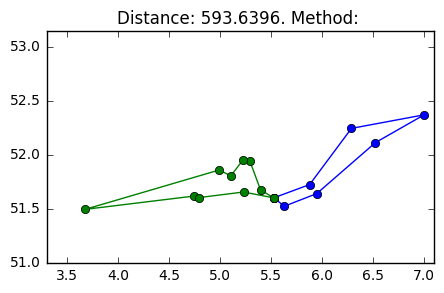

In [128]:
VRP.solve()
ilp_routes = get_route_ilp(VRP)
plot_routes(ilp_routes, figure_size = (5,3))

In [129]:
save_result(ilp_routes, 1)

### <a name="exercise2">5. Exercise 2 - NN</a> 
[Back to Table of Contents](#table)

The nearest neighbor algorithm is used to get an initial solution for the problem. I have implemented the algorithm as follows. It starts at the headquarters and finds the closest city to HQ. If the total distance + distance to closest city + distance from closest city back to HQ is lower than 400km, the city is added to the list of routes. Then that city is updated to the current city and the process repeats itself until adding a new city would result in a route longer than 400km. Each added city is removed from the list of cities that are not visited. After a route is completed the algorithm starts again from HQ.   
  
The following constraints are applied:
* Every route cannot be longer than 400km
* No subroutes are allowed within a route
* All cities in a route are not visited in another route

The result can be seen below. 

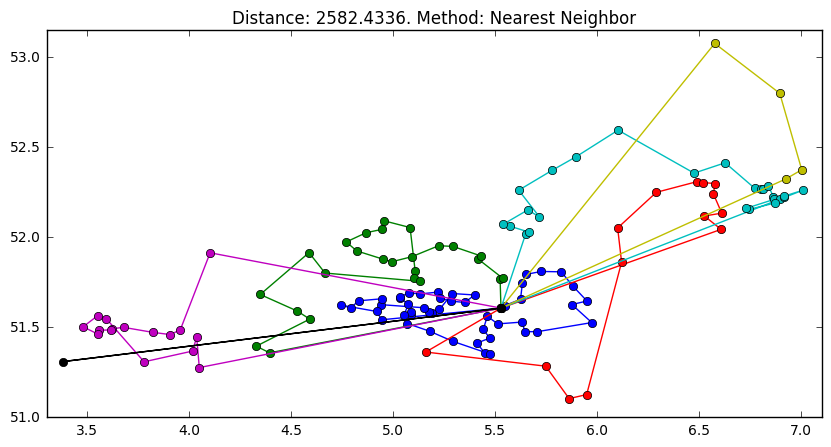

In [4]:
result_nearest = nearest_neighbor(distances)
plot_routes(result_nearest, 'Nearest Neighbor', figure_size=(10, 5))

### <a name="exercise3">6 Exercise 3</a> 
#### <a name="cityswap">6.1 City Swap</a> 
[Back to Table of Contents](#table)

City swap is implemented as a within-route consecutive city swap. In other words, it tries to swap consecutive cities in a single route and returns a route as soon as it is better then the starting route. The result is a marginally better result if ran once. However, if ran multiple times you get a significant better result

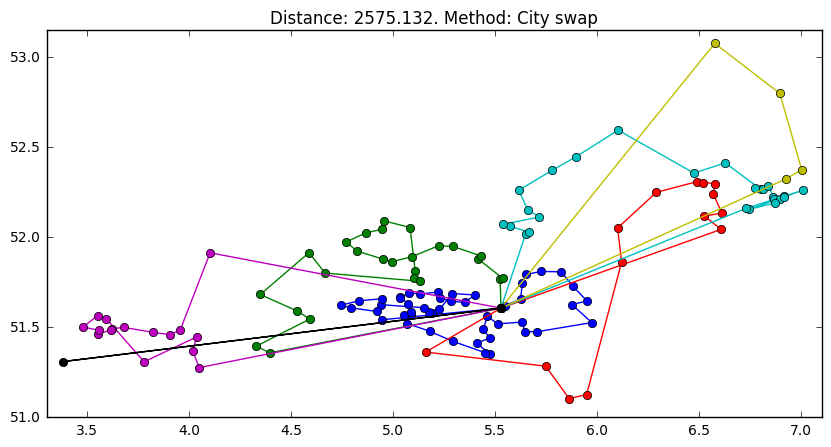

In [5]:
results_city_swap = {i: city_swap(result_nearest[i][1]) for i in result_nearest}
plot_routes(results_city_swap, 'City swap', figure_size=(10, 5))

### <a name="cityswapext">6.2 City Swap (between routes)</a> 
[Back to Table of Contents](#table)

In order to further improve the results I implemented a 
between route version of city swap. This heuristic tries to 
swap each cities in a route with the closest city in another route. 
It returns as soon as it finds a solution that is better than 
the initial solution. 

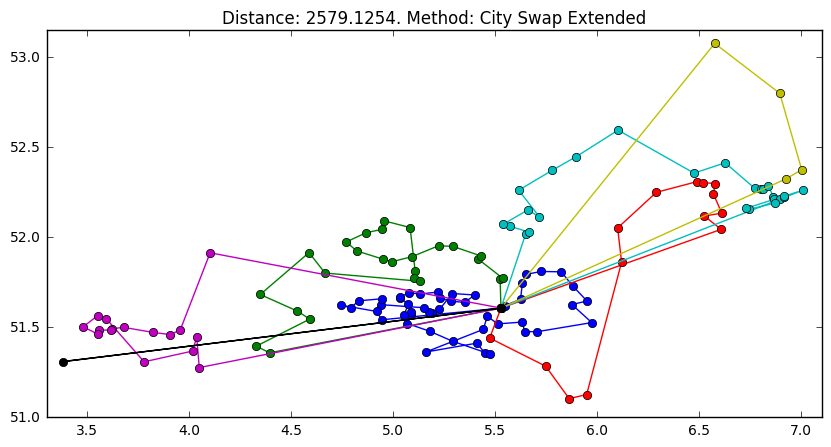

In [6]:
results_city_ext = city_swap_extended(result_nearest)
plot_routes(results_city_ext, 'City Swap Extended', figure_size=(10, 5))

### <a name="twoopt">6.3 Two-opt Exchange (within routes)</a> 
[Back to Table of Contents](#table)

This version of two-opt exchange work by selecting a subroute within a route and reversing the order. Reversing of the order is done as illustrated below:


<img src = "https://upload.wikimedia.org/wikipedia/commons/thumb/b/b8/2-opt_wiki.svg/306px-2-opt_wiki.svg.png">

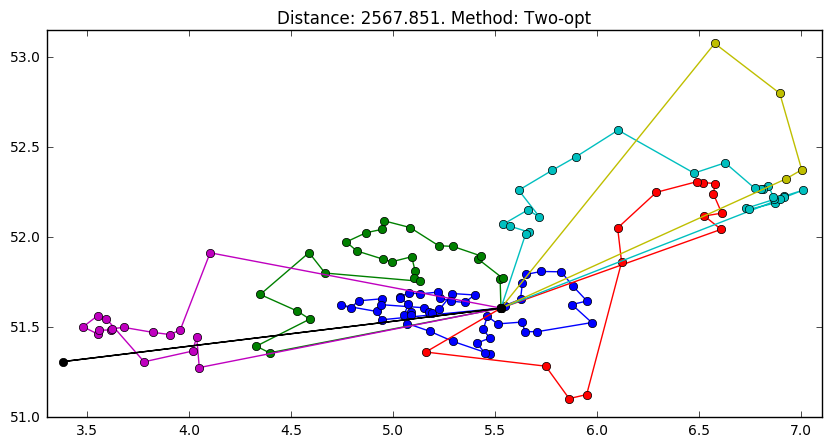

In [7]:
results_two_opt = {i: two_opt_step(result_nearest[i][1]) for i in result_nearest}
plot_routes(results_two_opt, 'Two-opt', figure_size=(10, 5))

### <a name="twooptb">6.4 Two-opt Exchange (between routes)</a> 
[Back to Table of Contents](#table)

A single iteration of a two-opt exchange between
different routes. The heuristic takes two routes and 
splits both of them in a random point to create the following
routes: 1A, 1B, 2A and 2B. Then, the routes are combined as
follows: (1A2A and 1B2B) or (1A2B, 1B2A). The algorithm checks
which one is better and returns as soon as the new route is 
better than the initial route. 

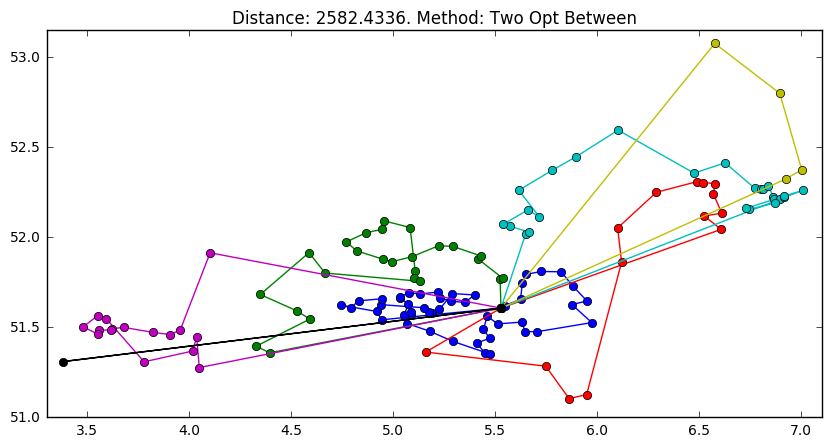

In [8]:
results_two_ext = two_opt_step_ext(result_nearest)
plot_routes(results_two_ext, 'Two Opt Between', figure_size=(10, 5))

### <a name="citytransfer">6.5 Transfer Cities</a> 
[Back to Table of Contents](#table)

This heuristic tries to move a city from one route to another in order to improve the resulting routes. Implicity, it tries to lower the number of routes as moving a city from a route with a single city reduces the total distance. 

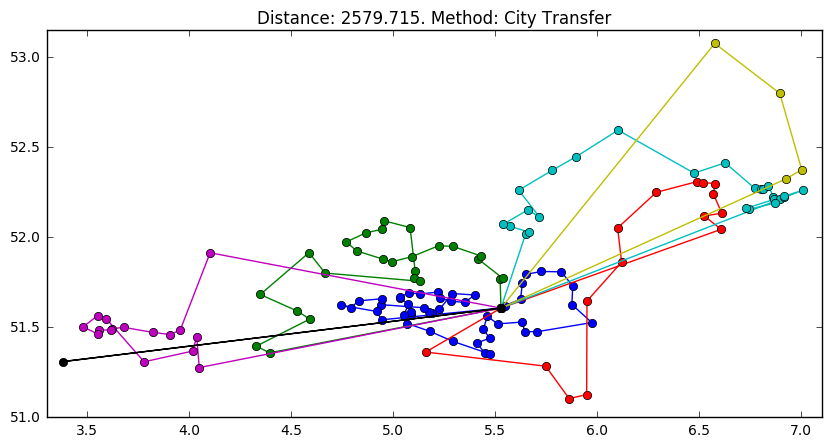

In [9]:
results_transfer = transfer_cities(result_nearest)
plot_routes(results_transfer, 'City Transfer', figure_size=(10, 5))

### <a name="removeroutes">6.6 Remove Routes</a> 
[Back to Table of Contents](#table)

This heuristic tries to move all cities in the 
smallest route to any other routes in order to 
minimize the number of routes. It allows for a worse
solution in order to decrease the number of routes
and perhaps explore more possible neighborhoods. 
It returns as soon as it has moved a city in the smallest
route to any other route and if it fits the constraints.

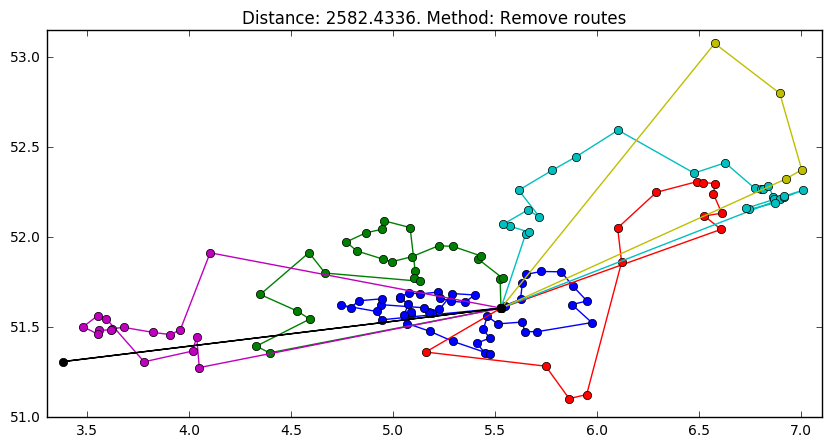

In [10]:
results_remove = remove_routes(result_nearest)
plot_routes(results_remove, 'Remove routes', figure_size=(10, 5))

### <a name="swap">6.7 Swap Subroutes</a> 
[Back to Table of Contents](#table)

This heuristic swaps a random subroute of one route
with the subroute of another. This is an extension
of the two-opt exchange between different routes. 
It returns as soon as the route is improved
  
For example:  
  
* route_1 = [0, 1, 2, 3, 4, 5, 6, 0]  
* route_2 = [0, 7, 8, 9, 10, 11, 12, 0]  
  
The algorithm may randomly swap subroute [3, 4] 
in route_1 with subroute [7, 8, 9, 10] in route_2 to 
get the following results:  
  
* route_1 = [0, 1, 2, 7, 8, 9, 10, 5, 6, 0]  
* route_2 = [0, 3, 4, 11, 12, 0]

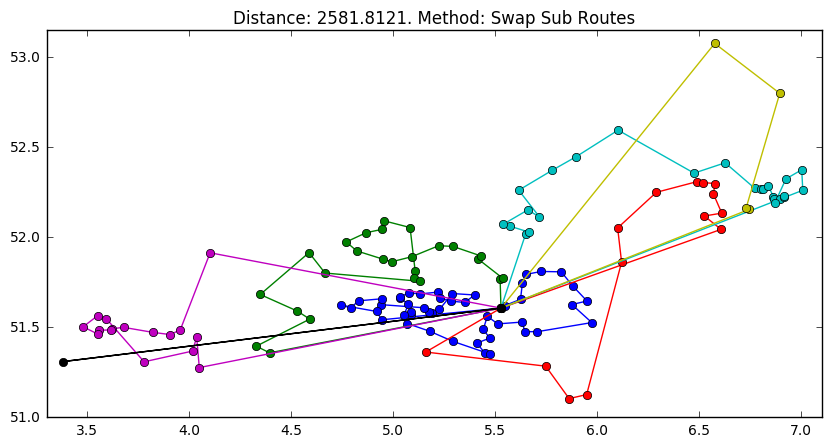

In [17]:
result_subroutes = swap(result_nearest)
plot_routes(result_subroutes, 'Swap Sub Routes', figure_size=(10, 5))

### <a name="tabu">6.8 Tabu Search</a> 
[Back to Table of Contents](#table)

An implementation of the tabu search heuristic.   

It uses seven heuristics (see functions for descriptions):
    * Concecutive city swap (within routes) 
    * City swap (between routes)
    * Two opt exchange (within routes)
    * Two opt exchange (between routes)
    * Transfer cities
    * Remove cities
    * Swap Sub Routes

For each iteration tabu search runs the six heuristics
and randomly picks a solution. These are random walks that
are executed in order to explore neighborhoods that might
lead to a better solution:   
  
Random walks: http://www-verimag.imag.fr/PUBLIS/uploads/hlevf2616.pdf  
  
The randomness of the implementation allows for different 
neighborhoods to be possible. Moreover, a tabu list is implemented
in order to allow the search to go back to an already seen solution
and go into a different neighborhood. It returns after a certain amount of iterations if there
has been no improvent for 10 consecutive iterations.

**Note:** Set the number of iterations at 20 if you want quick results. Increasing the number of iterations will obviously result in a better score, but will take a while to run. 

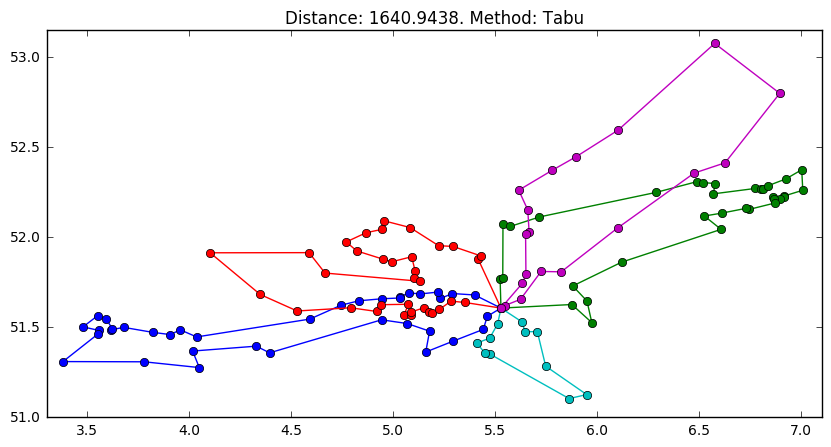

In [14]:
tabu, tabu_distances, intermediary_results = tabu_search(result_nearest, 1000, 950)
plot_routes(tabu, 'Tabu', figure_size=(10, 5))

# index_min = np.argmin(tabu_distances) # To get the best result in the list

In [15]:
fancy_plot(tabu)

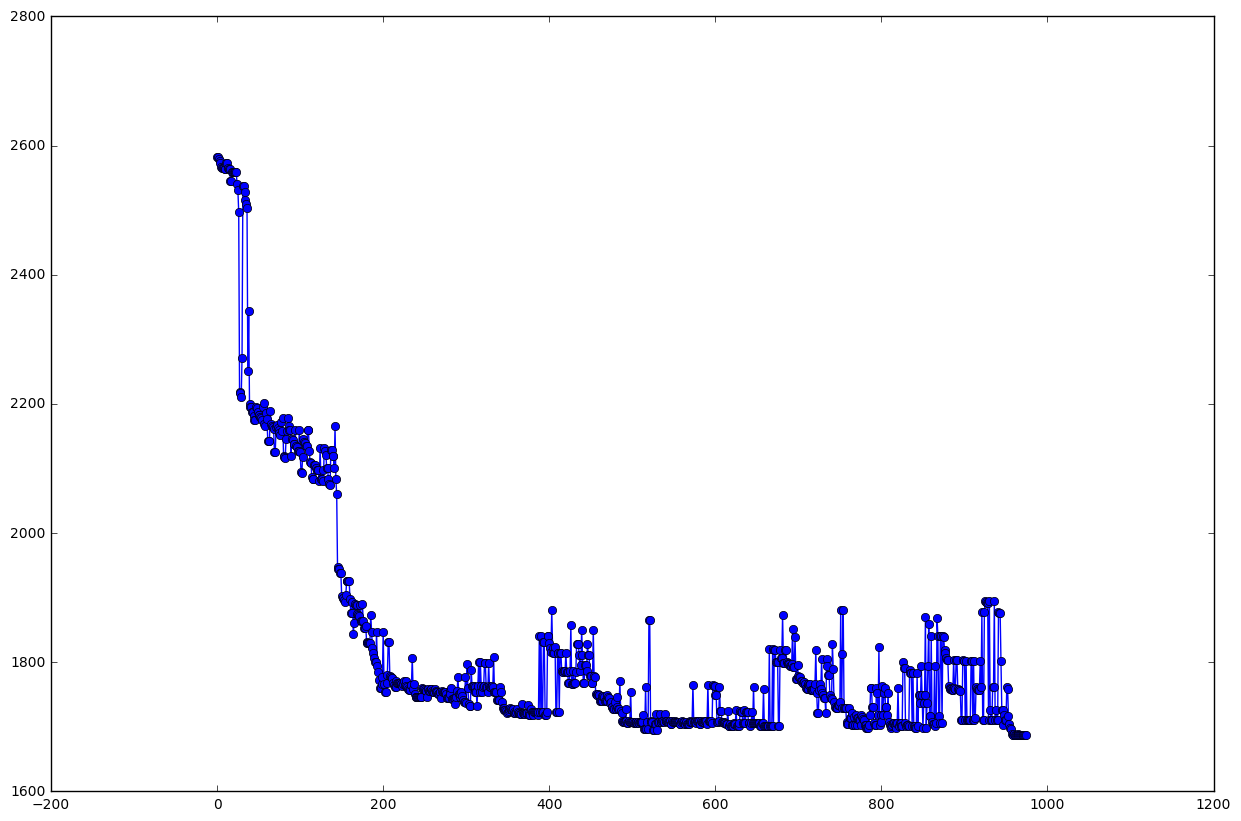

In [19]:
plt.figure(figsize=(15,10))
xseries = [i for i in range(len(tabu_distances))]
yseries = [i for i in tabu_distances]
plt.scatter(xseries,yseries)
plt.plot(xseries,yseries,linestyle='-', marker='o')
plt.show()

In [15]:
# Used to load in the best solution so I can again work with the results

# best_routes = pd.read_excel('Ex1.3-1052756-1640.xls')
# best_routes = {i: [0, list(best_routes[best_routes['Route Nr.'] == i]['City Nr.'])] 
#                    for i in best_routes['Route Nr.'].unique()}

### <a name="exercise4">7. Exercise 4</a> 
[Back to Table of Contents](#table)

#### <a name="siman">7.1 Simmulated Annealing</a> 
[Back to Table of Contents](#table)

An implementation of Simmulated Annealing as a TSP solution. In other words, we run Simmulated Annealing for each individual route in order to optimize the within distances. It should be note that I use the starting solution received in exercise 1.2 as my solution in 1.3 is too optimized for Simmulated Annealing to make a difference. 

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000        304.80   100.00%     0.00%     0:00:01     0:00:00

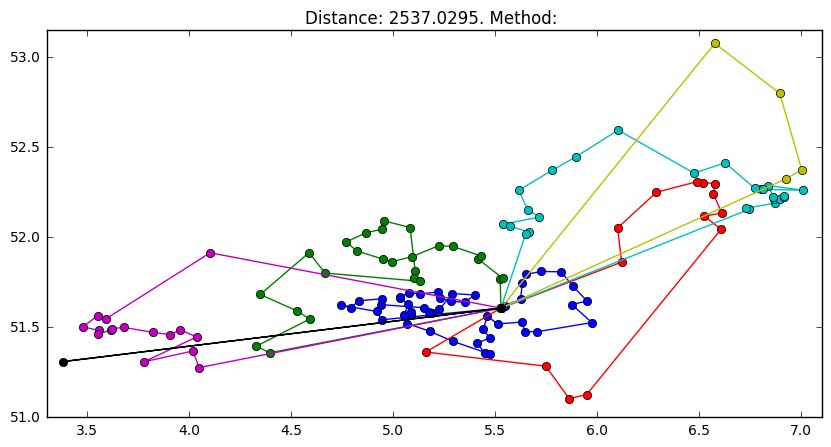

In [18]:
results_sa = {i: simmulated_annealing(result_nearest[i][1]) 
                   for i in result_nearest}
plot_routes(results_sa, figure_size=(10, 5))

#### <a name="aco">7.2 Ant Colony Optimization</a> 
[Back to Table of Contents](#table)

An implementation of Ant Colony as a TSP solution. In other words, we run Ant Colony for each individual route in order to optimize the within distances. I run this after running simmulated annealing in order to improve the initial results. 

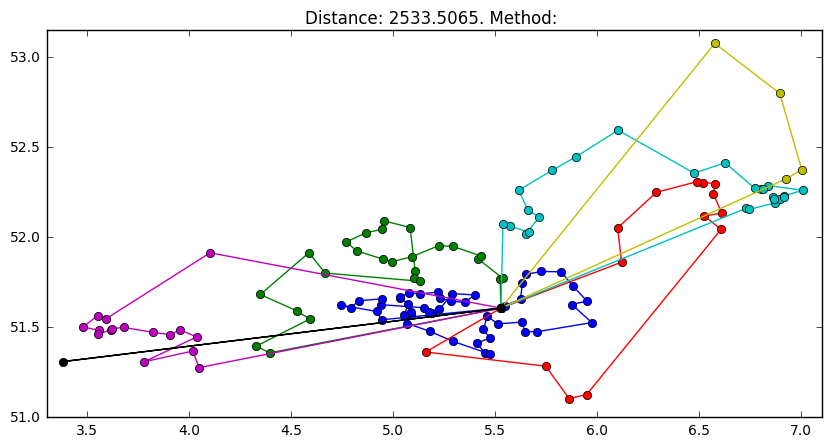

In [19]:
results_ac = {i: ant_colony(results_sa[i][1]) 
                   for i in results_sa}
plot_routes(results_ac, figure_size=(10, 5))

### <a name="exercise5">8. Exercise 5</a> 
[Back to Table of Contents](#table)

Exercise 5 was solved in two ways:
* A heuristic (tabu search) with all cities
* ILP (pulp) with only 15 cities

#### <a name="functions5">8.1 Functions</a> 
[Back to Table of Contents](#table)

In [36]:
import copy

def nearest_neighbor(df):   
    """ Returns a list of routes based on an implementation
        of the nearest neighbor heuristic. The routes have
        the following constraints:
           * Every route cannot be longer than 400km
           * No subroutes are allowed
           * All cities in a route are not visited in another route
           * Stores are open between 9.00 and 17.00
           * Stores visited take 1 hour
           * A store must be visisted before 16.00
           * A manager can leave HQ before 9.00
           * A manager can work at most 10 hours a day
                   
    Parameters:
    -----------
        df (dataframe): Distance matrix of distances between each city

    Returns:
    --------
        routes (dictionary): Dictionary of lists which contain cities 
                            in the correct order
    """
    
    routes = {}

    while len(df) > 1:    
        current_city = 0
        total_distance = 0
        route = [0, 0]
        manager_time = 0
        store_time = 9
        
        while True:
            new_city_distance = df.drop([current_city, 0], axis=1).ix[current_city].min()
            new_city = int(df.drop([current_city, 0], axis=1).ix[current_city].idxmin())
            distance_to_hq = df.ix[new_city][0]
            
            temp_manager_time = manager_time
            temp_manager_time += (new_city_distance + distance_to_hq) / 80 + 1
            
            if len(route) == 2:
                temp_store_time = store_time
            else:
                temp_store_time = store_time
                temp_store_time += (new_city_distance + distance_to_hq) / 80 + 1

            # Check if "future" distance matches with current distance
            if ((total_distance + new_city_distance + distance_to_hq) < 400) & \
                        (temp_manager_time <= 10) & (temp_store_time <= 16):
                manager_time += new_city_distance / 80 + 1
                            
                if len(route) > 2:
                    store_time += (new_city_distance / 80) + 1
                    
                # Remove city from places to visit
                if current_city != 0:
                    df = df.drop(current_city)
                    df = df.drop(current_city, axis = 1)

                # Update Route and set the starting city to the closest one
                current_city = new_city
                
                route.insert(-1, int(new_city))
                total_distance += new_city_distance

                # If there is only 1 city left we take that as a single route
                if len(df) == 2:                   
                    total_distance += distance_to_hq
                    routes[len(routes) + 1] = [total_distance, route, manager_time + \
                                               distance_to_hq/80]
                    df = df.drop(current_city)
                    break

            # Signifies the end of a route
            else:
                total_distance += distance_to_hq
                routes[len(routes) + 1] = [total_distance, route, manager_time+ distance_to_hq/80]
                df = df.drop(current_city)
                df = df.drop(current_city, axis = 1)
                break
                
    return routes

def city_swap(route): 
    """ Single iteration of a consecutive city swap
    
    City swap is implemented as a within-route consecutive
    city swap. In other words, it tries to swap consecutive 
    cities in a single route and returns a route as soon
    as it is better then the starting route. 
    
    Parameters:
    -----------
        route (list): Route with cities as integers in a list
        
    Returns:
    -----------
        list(float, list): list(distance of top route, the top route)
    
    """
    top_route = deepcopy(route)
    top_route_distance = get_distance_route(route)
    
    if len(route) > 3:
        for i in range(1, len(route)-2):
            temp_route = deepcopy(top_route)
            temp_route[i], temp_route[i+1] = temp_route[i+1], temp_route[i]
            if check_validity_single_route(temp_route, top_route_distance):
                top_route = temp_route
    return [top_route_distance, top_route]



def two_opt_step(route):
    """ Single iteration of a two-opt exchange
    """
    top_route = route
    top_route_distance = get_distance_route(route)
    
    if len(route) > 2:
        for i in range(1, len(route)-2):
            for j in range(i+1, len(route)):
                temp_route = route[:i] + route[i:j][::-1] + route[j:]
                temp_route_distance = get_distance_route(temp_route)

                if check_validity_single_route(temp_route, top_route_distance):
                    top_route = temp_route
                    top_route_distance = temp_route_distance
                    return [top_route_distance, top_route]
    return [top_route_distance, top_route]


def two_opt_step_ext(routes):
    """ Single iteration of a two-opt exchange
    
    This version of two-opt exchange is implemented as an within
    route two-opt exchange. Thus, within a route, a piece of the
    route is reversed in order to possibly optimize the route. 
    It returns as soon as it finds a better solution than the
    initial route. 
    
    Parameters:
    -----------
        route (list): Route with cities as integers in a list
    
    Returns:
    -----------
        list(float, list): list(distance of top route, the top route)
    
    """
    top_routes = routes
    top_distance = get_distance_routes(routes)
    
    for route_1 in top_routes:
        for route_2 in top_routes:
            if (route_1 != route_2) & (len(top_routes[route_1][1])>3) &\
                                      (len(top_routes[route_2][1])>3):
                for i in range(1, len(top_routes[route_1][1])-1):
                    temp_route = deepcopy(top_routes)
                    temp_route_2 = deepcopy(top_routes)
                    
                    # Get a random cut-off point for the second route
                    j = {key: distances_dict[i][key] for key in temp_route[route_2][1]}
                    j.pop(0, None)
                    j.pop(i, None)
                    j = min(j, key=j.get)
                    j = temp_route[route_2][1].index(j)
                    
                    # 1A2B + 1B2A
                    temp_route[route_1][1] = top_routes[route_1][1][:i] + \
                                             top_routes[route_2][1][j:]
                    temp_route[route_2][1] = top_routes[route_2][1][:j] + \
                                             top_routes[route_1][1][i:]
                    
                    # 1A2A + 1B2B 
                    temp_route_2[route_1][1] = top_routes[route_1][1][:i] + \
                                               top_routes[route_2][1][1:j][::-1] + [0]
                    temp_route_2[route_2][1] = top_routes[route_2][1][j:][::-1] + \
                                               top_routes[route_1][1][i:]
                    
                    # Get new distances and check for validity
                    temp_distance = [get_distance_route(temp_route[i][1]) for i in temp_route]                    
                    temp_distance_2 = [get_distance_route(temp_route_2[i][1]) for i in temp_route_2]                    

                    if sum(temp_distance_2) < sum(temp_distance):
                        temp_route = temp_route_2
                        temp_distance = temp_distance_2
                    
                    if check_validity_multiple_routes(temp_route, top_distance):
                        return temp_route                    
    return top_routes

def city_swap_extended(routes):
    """ A between route version of city swap
    
    An extended version of the consecutive city swap. 
    This heuristic tries to swap each cities in a route
    with the closest city in another route. It returns
    as soon as it finds a solution that is better than 
    the initial solution. 
    
    Parameter:
    -----------
        routes (dict(int, list)): dictionary of multiple routes
    
    Returns:
    -----------
        dict(int, list): dictionary of multiple routes
    """

    top_routes = deepcopy(routes)
    top_distance = get_distance_routes(top_routes)
    
    for route_1 in top_routes:
        for route_2 in top_routes:
            try:
                for ix_1, city in enumerate(top_routes[route_1][1]):
                    if (city != 0) & (route_1 != route_2) & (len(top_routes[route_2][1]) > 2):
                        
                        # Find the closest city in another route
                        temp = deepcopy(top_routes)
                        city_2 = {key: distances_dict[city][key] for key in temp[route_2][1]}
                        city_2.pop(0, None)
                        city_2.pop(city, None)
                        city_2 = min(city_2, key=city_2.get)
                        ix_2 = temp[route_2][1].index(city_2)
                        
                        # Swap the cities between routes
                        temp[route_1][1][ix_1], temp[route_2][1][ix_2] = temp[route_2][1][ix_2],\
                                                                         temp[route_1][1][ix_1]

                        temp_distance = [get_distance_route(temp[i][1]) for i in temp]                    

                        # Check if it fits the constraints and better then initial solution
                        if (all(dist < 400 for dist in temp_distance)) and \
                                check_validity_multiple_routes(temp, top_distance):
                            top_routes = deepcopy(temp)
                            top_distance = temp_distance
                            return top_routes
            except:
                return top_routes
    return top_routes

def transfer_cities(routes):
    """ Heuristic to transfer cities to a new route
    
    This heuristic tries to move a city from one route
    to another in order to improve the resulting routes. 
    Implicity, it tries to lower the number of routes as 
    moving a city from a route with a single city reduces
    the total distance. 
            
    Parameter:
    -----------
        routes (dict(int, list)): dictionary of multiple routes
    
    Returns:
    -----------
        dict(int, list): dictionary of multiple routes
    
    """
    # Initialize top route and distance
    top_routes = deepcopy(routes)
    top_distance = get_distance_routes(top_routes)

    for route_1 in top_routes:
        for route_2 in top_routes:
            for ix_1, city in enumerate(top_routes[route_1][1]):
                if (city != 0) & (route_1 != route_2) & (len(top_routes[route_2][1])>2):
                    temp = deepcopy(top_routes)      
                    
                    # Find closest city 
                    city_2 = {key: distances_dict[city][key] for key in temp[route_2][1]}
                    city_2.pop(0, None)
                    city_2.pop(city, None)
                    city_2 = min(city_2, key=city_2.get)
                    ix_2 = temp[route_2][1].index(city_2)
                    
                    # Move city to new route and calculate new distance
                    temp[route_2][1].insert(ix_2, city)
                    del temp[route_1][1][ix_1]
                    temp_distance = [get_distance_route(temp[i][1]) for i in temp]                    
                    
                    # Check if solution is better
                    if check_validity_multiple_routes(temp, top_distance) & \
                       (all(dist < 400 for dist in temp_distance)):
                        if len(temp[route_1][1]) < 3:
                            del temp[route_1]
                            return temp
                        else:
                            return temp
    return top_routes

def remove_routes(routes):
    """ Heuristic to decrease the amount of routes
    
    This heuristic tries to move all cities in the 
    smallest route to any other routes in order to 
    minimize the number of routes. It allows for a worse
    solution in order to decrease the number of routes
    and perhaps explore more possible neighborhoods. 
    It returns as soon as it has moved a city in the smallest
    route to any other route and if it fits the constraints.
    
    Parameter:
    -----------
        routes (dict(int, list)): dictionary of multiple routes
    
    Returns:
    -----------
        dict(int, list): dictionary of multiple routes
    
    """
    # Initialize top route and distance
    top_routes = deepcopy(routes)
    top_distance = get_distance_routes(top_routes)
    
    # Find smallest route
    smallest_route = {i: len(top_routes[i][1]) if len(top_routes[i][1]) > 2 else 100 
                      for i in top_routes}
    smallest_route = min(smallest_route, key=smallest_route.get)
    
    
    for route in top_routes:
        for city in range(1, len(top_routes[route][1])-1):
            for ix_1, city_1 in enumerate(top_routes[smallest_route][1]):
                if (city_1 != 0) & (route != smallest_route):
                    
                    # Move a city to a new route and calculate new distance
                    temp = deepcopy(top_routes)
                    temp[route][1].insert(city, city_1)
                    del temp[smallest_route][1][ix_1]
                    temp_distance = [get_distance_route(temp[i][1]) for i in temp]    
                    
                    # Check if the new route fits the constraints
                    if check_validity_multiple_routes(temp, 5000) & \
                       (all(dist < 400 for dist in temp_distance)):     
                        if len(temp[smallest_route][1]) < 3:
                            del temp[smallest_route]
                            return temp
                        else:
                            return temp
    return top_routes


def check_validity_single_route(temp_route, top_route_distance):
    """ Check the validity of a route
    
    It checks the validity of a single route and
    returns True if the constraints are met and
    False otherwise. 
    
    Parameter:
    -----------
        temp_route (list): List of integers that signify cities
        top_route_distance (float): To check whether this route is 
                                    better than the top route
        
    Returns:
    -----------
        Binary (True/False): True if constraints are met
                             False otherwise
        
    """
    
    temp_route_distance = get_distance_route(temp_route)
    manager_time = temp_route_distance / 80 + len(temp_route) - 2
    store_time = (get_distance_route(temp_route[1:-1]) / 80) + len(temp_route[1:-1]) - 1 + 9

    if (temp_route_distance < top_route_distance) & (manager_time < 10) & \
       (store_time <= 16):
        return True
    else:
        return False

def check_validity_multiple_routes(temp_route, top_route_distance):
    """ Check the validity of all routes
    
    It checks the validity of a set of routes and
    returns True if the constraints are met and
    False otherwise. 
    
    Parameter:
    -----------
        routes (dict(int, list)): dictionary of multiple routes
        top_route_distance (float): To check whether this route is 
                                    better than the top route
        
    Returns:
    -----------
        Binary (True/False): True if constraints are met
                             False otherwise
        
    """
    temp_route_distance = get_distance_routes(temp_route)
    validity = True
    
    for route in temp_route:
        manager_time = get_distance_route(temp_route[route][1]) / 80 + \
                                    len(temp_route[route][1]) - 2
        store_time = (get_distance_route(temp_route[route][1][1:-1]) / 80) + \
                                    len(temp_route[route][1][1:-1]) - 1 + 9
        
        if (manager_time < 10) & (store_time <= 16):
            continue
        else:
            return False
    
    if temp_route_distance < top_route_distance:
        return True
    else:
        return False

def tabu_search(routes, max_iter=400):
    """ Tabu search heuristic
    
    An implementation of the tabu search heuristic. 
    It uses six heuristics (see functions for describtions):
        * Concecutive city swap (within routes) 
        * City swap (between routes)
        * Two opt exchange (within routes)
        * Two opt exchange (between routes)
        * Transfer cities
        * Remove cities
        
    For each iteration tabu search runs the six heuristics
    and randomly picks a solution. These are random walks that
    are executed in order to explore neighborhoods that might
    lead to a better solution: 
    
    Random walks: http://www-verimag.imag.fr/PUBLIS/uploads/hlevf2616.pdf
    
    The randomness of the implementation allows for different 
    neighborhoods to be possible. Moreover, a tabu list is implemented
    in order to allow the search to go back to an already seen solution
    and go into a different neighborhood. 
    
    It returns after a certain amount of iterations if there
    has been no improvent for 10 consecutive iterations.
    
    Parameter:
    -----------
        routes (dict(int, list)): dictionary of multiple routes
        max_iter (int): Number of maximum iterations
    
    Returns:
    -----------
        dict(int, list): dictionary of multiple routes
    
    
    """
    best_routes = deepcopy(routes)
    best_solution = get_distance_routes(routes)
    length_tabu = 10
    tabu_list = collections.deque(maxlen=length_tabu)
    k = 0
    result_list = [best_solution] 
    route_list = [{'start': best_routes}]
    
    while k < max_iter:     
        results_two_opt = {i: two_opt_step(best_routes[i][1]) for i in best_routes}
        results_two_opt_ext = two_opt_step_ext(best_routes)
        results_city_swap = {i: city_swap(best_routes[i][1]) for i in best_routes}
        results_city_ext = city_swap_extended(best_routes)
        results_transfer = transfer_cities(best_routes)
        results_remove = remove_routes(best_routes)

        routes = {'Swap': results_city_swap,
                 'Ext': results_city_ext,
                 'Two_opt': results_two_opt,
                 'Transfer': results_transfer,
                 'Remove': results_remove,
                 'Two_opt_ext': results_two_opt_ext}
        
        dist = {'Swap': get_distance_routes(results_city_swap),
                'Ext': get_distance_routes(results_city_ext),
                'Two_opt': get_distance_routes(results_two_opt),
               'Transfer': get_distance_routes(results_transfer),
               'Remove': get_distance_routes(results_remove),
               'Two_opt_ext': get_distance_routes(results_two_opt_ext)}
       
        
        random_route = random.choice(list(routes.keys()))
        new_best_routes = routes[random_route] # get random solution
        
        new_best_solution = get_distance_routes(new_best_routes) 
        tabu_list.appendleft(new_best_routes)                  
        
        if new_best_solution < best_solution:
            best_solution = deepcopy(new_best_solution)
            best_routes = deepcopy(new_best_routes)
        else:
            random_int = np.random.randint(0,len(tabu_list))
            best_routes = tabu_list[random_int]
            best_solution = get_distance_routes(tabu_list[random_int])
            
        result_list.append(new_best_solution)
        route_list.append({random_route: best_routes})
        k += 1
        
        if (all(x==tabu_list[0] for x in tabu_list)) & (len(tabu_list) == length_tabu):
            return best_routes, result_list, route_list

        
        if k % 40 == 0:
            print('Done with {} iterations'.format(k))
    return best_routes, result_list, route_list

#### <a name="nn5">8.2 Nearest Neighbor</a> 
[Back to Table of Contents](#table)

Again, an initial solution was created using Nearest Neighbor. 

The following constraints are implemented:
* Every route cannot be longer than 400km
* No subroutes are allowed
* All cities in a route are not visited in another route
* Stores are open between 9.00 and 17.00
* Stores visited take 1 hour
* A store must be visisted before 16.00
* A manager can leave HQ before 9.00
* A manager can work at most 10 hours a day

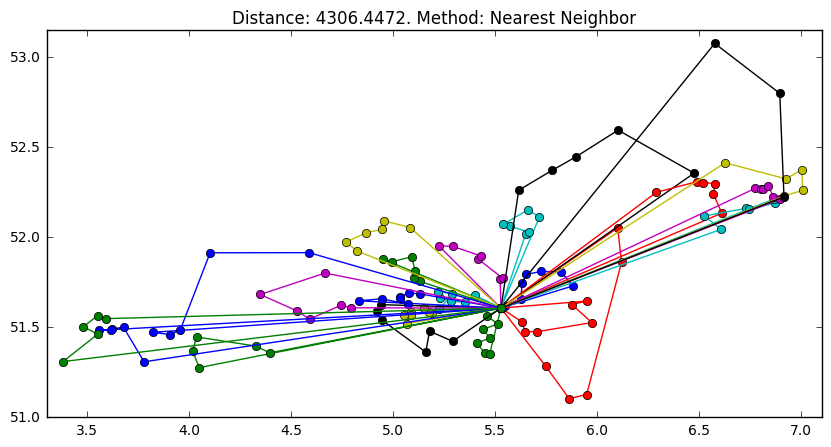

In [37]:
result_test = nearest_neighbor(distances)
plot_routes(result_test, 'Nearest Neighbor', figure_size=(10, 5))

#### <a name="tabu5">8.3 Tabu Search</a> 
[Back to Table of Contents](#table)

Done with 40 iterations
Done with 80 iterations
Done with 120 iterations
Done with 160 iterations
Done with 200 iterations
Done with 240 iterations
Done with 280 iterations
Done with 320 iterations
Done with 360 iterations
Done with 400 iterations


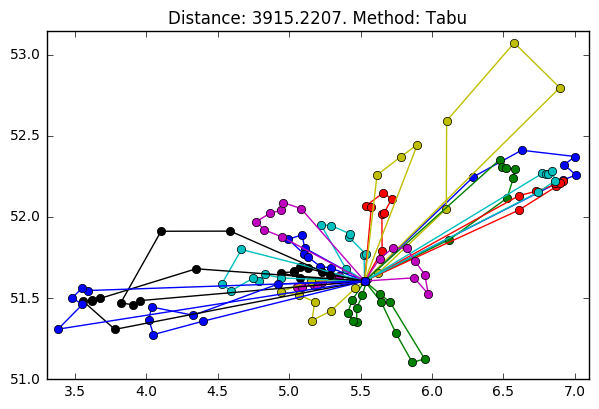

In [13]:
tabu, tabu_distances, intermediary_results = tabu_search(result_test, 400)
plot_routes(tabu, 'Tabu', figure_size=(7, 4.5))

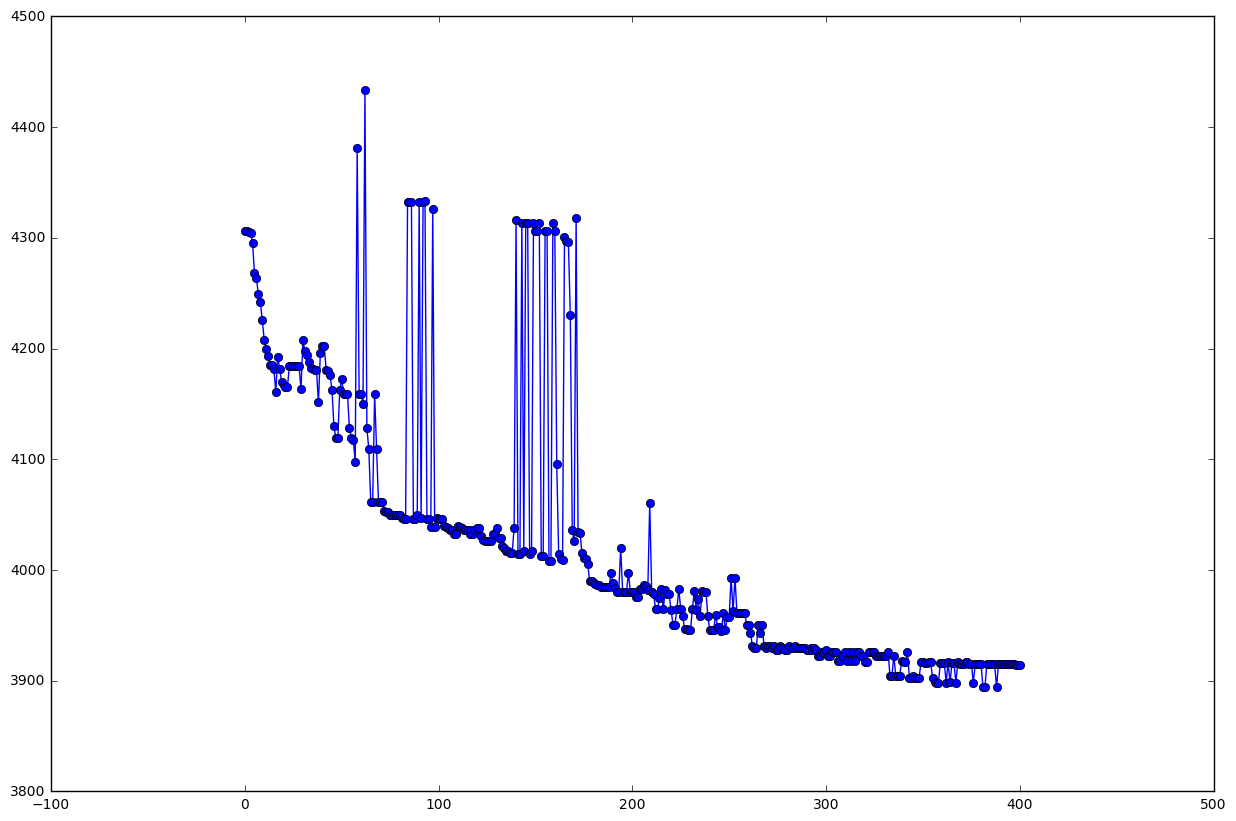

In [14]:
plt.figure(figsize=(15,10))
xseries = [i for i in range(len(tabu_distances))]
yseries = [i for i in tabu_distances]
plt.scatter(xseries,yseries)
plt.plot(xseries,yseries,linestyle='-', marker='o')
plt.show()

#### <a name="ilp5">8.4 ILP - Version</a> 
[Back to Table of Contents](#table)

I wanted to practice with ILP which I why the exercise was also solved using pulp. The following sources were used to derive which additional constraints needed to be implemented:
* http://www.alvarestech.com/temp/vrptw/Vehicle%20Routing%20Problem%20with%20Time%20Windows.pdf
* http://www.bernabe.dorronsoro.es/vrp/data/articles/VRPTW.pdf



<img src= https://wikimedia.org/api/rest_v1/media/math/render/svg/210952104494d8add3acf817d00c2a1be0c97a81>

For i = 1, …, n, let $u_{i}$ be a dummy variable, and finally take $c_{ij}$ to be the distance from city i to city j. Then TSP can be written as the following integer linear programming problem:


**Objective function:**
We want to minimize the total distance traveled for each manager.

$$min \sum_{i=1}^n \sum_{i\neq j, j=1}^n \sum_{k=1}^n c_{ij} x_{ijk} \tag{1}\label{eq:one}$$

Basically we add a summation for the account managers and specify that for each manager the distance need to be minimized. Moreover, the summation for the account manager is also to $n$ because there cannot be more routes than cities.

**Constraints**


$$\sum_{i\neq j, i=1}^n  \sum_{k=1}^n x_{ijk}= 1, \quad\forall_i \in N  \tag{2}\label{eq:two}  $$


$$\sum_{j=1}^n x_{0jk} = 1, \quad\forall_k \in K  \tag{3}\label{eq:three}$$


$$\sum_{i\neq j, i=1}^n x_{ijk} - \sum_{j\neq i, j=1}^n x_{jik} = 0,\quad \forall_k \in K, \forall_j \in N  \tag{4}\label{eq:four}$$

$$\sum_{i\neq j, i=1}^n  \sum_{j=1}^n x_{ijk} \cdot c_{ij} \leq 400, \quad\forall_k \in K  \tag{5}\label{eq:five}$$

$$\sum_{i\neq j, i=1}^n  \sum_{j=1}^n x_{ijk} * (c_{ij} / 80) + x_{ijk} \leq 10, \quad\forall_k \in K  \tag{6}\label{eq:six}$$

$$ 1 + w_{ik} + c_{ij} / 80 - w_{jk} \leq (1 - x_{ijk}) * max\{16 + 1 + c_{ij} / 80 - 9, 0 \},\quad \forall_k \in K, \forall_{i,j} \in N  \tag{7}\label{eq:seven}$$

**Describtion Constraints**  
(1) This is the objective function that we want to minimize.     
(2) Every location can be visited once.  
(3) Each truck is used at most once.  
(4) If a truck arives in a location it also leaves from that location.  
(5) A route cannot be longer than 400 km.  
(6) A manager can only work 10 hours a day  
(7) Capacity (time) constraint

In [27]:
#############
# Get Data #
#############
small_data = pd.read_excel('data_small.xlsx')
dist_matrix = get_distance_matrix(small_data)

#################
# Set Variables #
#################
locations = list(range(0, small_data["Nr. "].shape[0]))
trucks = list(range(3)) # reduce this to 3 if you want a quick solution
n = len(locations)

Xijk = pulp.LpVariable.dicts("Edge", [(i,j,k) 
                                                  for i in locations 
                                                  for j in locations 
                                                  for k in trucks if i!=j], 0, 1, pulp.LpBinary)

######################
# Objective function #
######################
VRP = pulp.LpProblem("VRP", pulp.LpMinimize)
VRP += pulp.lpSum([Xijk[(i,j,k)] * dist_matrix[i,j] 
                   for i in locations 
                   for j in locations 
                   for k in trucks if i!=j])


###############
# Constraints #
###############

# Every location visited once
for i in locations[1:]:
    VRP += pulp.lpSum([Xijk[(i,j,k)] 
                       for j in locations 
                       for k in trucks if i!=j]) == 1 

# Each truck is used at most once
for k in trucks:
    VRP += pulp.lpSum([Xijk[(0,j,k)] 
                       for j in locations[1:]]) == 1

# If a truck arives in a location it also leaves from that location
for p in locations:
    for k in trucks:
        VRP += pulp.lpSum([Xijk[(i,p,k)] 
                           for i in locations if i !=p]) - pulp.lpSum([Xijk[(p,j,k)] 
                                for j in locations if p!=j]) == 0

# A route cannot be longer than 400 km
for k in trucks:
    VRP += pulp.lpSum([Xijk[(i,j,k)] * dist_matrix[i,j] 
                       for i in locations 
                       for j in locations if i != j]) <= 400

###################
# New Constraints #
###################

# New variable to indicate the time at a location
wik = pulp.LpVariable.dicts('Time', [(i,k) 
                                            for i in locations 
                                            for k in trucks],9,16)

# A manager can only work for 10 hours a day
for k in trucks:
    VRP += pulp.lpSum(Xijk[(i,j,k)] * dist_matrix[i, j]/80 + Xijk[(i,j,k)]
                    for i in locations 
                    for j in locations if i!=j) <= 10


# A store is only open between 9 and 17
for i in locations[1:]:
    for j in locations[1:]:
        if i!=j:
            for k in trucks:
                VRP += (1 + wik[(i, k)] + dist_matrix[i, j]/80 - wik[(j,k)]
                       <= (1-Xijk[(i,j,k)]) * max((16+1+dist_matrix[i, j]/80-9), 0))

start = time.time()
VRP.solve(pulp.PULP_CBC_CMD(maxSeconds = 40, msg=1, fracGap=0))
print(time.time() - start)

40.417736530303955


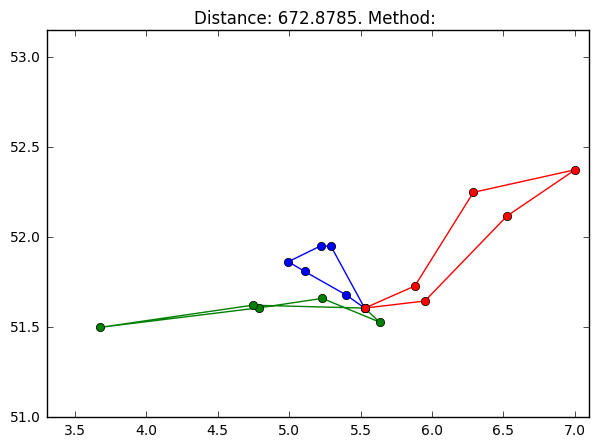

In [132]:
ilp_routes = get_route_ilp(VRP)
plot_routes(ilp_routes, figure_size = (7,5))

In [133]:
fancy_plot(ilp_routes)